In [1]:
from tensorflow.keras.datasets import mnist

(xtrain, ytrain), (xtest, ytest) = mnist.load_data()

In [2]:
from matplotlib import pyplot as plt

In [3]:
xtrain[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

KeyboardInterrupt: 

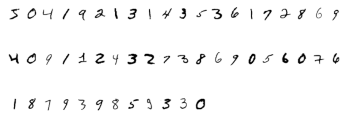

In [4]:
for i in range(100):
    plt.subplot(5, 20, i+1)
    plt.imshow(xtrain[i], cmap=plt.cm.Greys)
    plt.axis('off')

In [ ]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import numpy as np

from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam


import pandas as pd

In [ ]:
# import TesorFolw libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LeakyReLU


- Check datta shape and info

In [ ]:
# Always always check shapes! 
xtrain.shape, xtest.shape

((60000, 28, 28), (10000, 28, 28))

In [ ]:
ytrain.shape, ytest.shape

((60000,), (10000,))

In [ ]:
np.unique(ytrain)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

((60000, 28, 28), (28, 28))

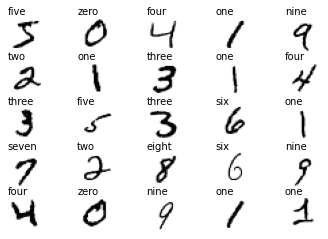

In [ ]:
class_names = ['zero', 'one', 'two', 'three', 'four',
               'five', 'six', 'seven', 'eight', 'nine']

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(xtrain[i], cmap='Greys')
    plt.axis('off')
    numeric_class = ytrain[i]
    text_class = class_names[numeric_class]
    plt.text(0, 0, text_class) # displays y-values in each subplot

xtrain.shape, xtrain[1].shape

zero


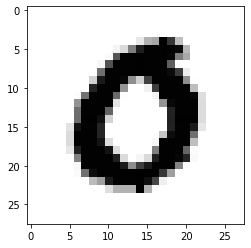

In [ ]:
pic = 8000
plt.imshow(xtrain[pic],cmap = 'Greys')
print(class_names[ytrain[pic]])

- flatten the pictures in an array to be able to input them in the model

In [ ]:
# from
xtrain[0].shape

(28, 28)

In [ ]:
# to
xtrain[0].flatten().shape

(784,)

In [ ]:
# flatten all train data
xtrain= xtrain.reshape(60000,-1)
xtrain.shape


(60000, 784)

In [ ]:
# one hot encoder
ytrain = to_categorical(ytrain)

# Blueprint

In [ ]:
# Always clear the session!
K.clear_session()

model = keras.models.Sequential()

# input layer
model.add(layers.Dense(units=10, 
                             activation="relu", 
                             input_shape=(784,) # shape of an image. must be the flattened array.
                            ))


# Batch Normalisation:
model.add(layers.BatchNormalization())

# hidden layer(s)
model.add(layers.Dense(units=20, 
             activation="relu"))



model.add(layers.Dropout(0.25))  # this layer deletes 25% of random parameters in the model. This layer ideally gpes in the end, before the output. 

# output layer
# units/neurons: number of classes
model.add(layers.Dense(units=10,
             activation="softmax")
)


In [ ]:
# model.compile(optimizer="Adam",
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [ ]:
from tensorflow.keras.optimizers import Adam
K.clear_session()
model.compile(optimizer=Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 8,320
Trainable params: 8,300
Non-trainable params: 20
_________________________________________________________________


In [ ]:
# Early stopping:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', #the thing we are monitoring
    min_delta=0.0005, #the minimum change in the quantity that we want for the model to train for another epoch
    patience=3, #number of epochs with no improvement needed for the model to stop
    verbose=1, #0 is silent, 1 means a message is displayed when something happens
    #Exercise! More things to look up in the documentation:
    #restore_best_weights
    #baseline
)

In [ ]:
hist = model.fit(xtrain, ytrain,
                 epochs=100, # 1 epoch is 1 iteration over entire X and y data
                 batch_size=600, # number of samples per gradient update
                 validation_split=0.2, #20% is the test set
                 callbacks = [early_stop]
                )

Epoch 1/100
80/80 [==============================] - 3s 12ms/step - loss: 1.6882 - accuracy: 0.4498 - val_loss: 0.9634 - val_accuracy: 0.7351
Epoch 2/100
80/80 [==============================] - 1s 11ms/step - loss: 1.0028 - accuracy: 0.7373 - val_loss: 0.5770 - val_accuracy: 0.8578
Epoch 3/100
80/80 [==============================] - 1s 9ms/step - loss: 0.7042 - accuracy: 0.8089 - val_loss: 0.4347 - val_accuracy: 0.8895
Epoch 4/100
80/80 [==============================] - 1s 8ms/step - loss: 0.5755 - accuracy: 0.8400 - val_loss: 0.3579 - val_accuracy: 0.9054
Epoch 5/100
80/80 [==============================] - 1s 9ms/step - loss: 0.5049 - accuracy: 0.8574 - val_loss: 0.3238 - val_accuracy: 0.9117
Epoch 6/100
80/80 [==============================] - 1s 9ms/step - loss: 0.4610 - accuracy: 0.8708 - val_loss: 0.2977 - val_accuracy: 0.9173
Epoch 7/100
80/80 [==============================] - 1s 9ms/step - loss: 0.4310 - accuracy: 0.8783 - val_loss: 0.2900 - val_accuracy: 0.9174
Epoch 8/100

<AxesSubplot:>

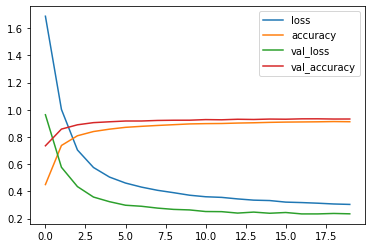

In [ ]:
# Plot model accuracy and loss:
pd.DataFrame(hist.history).plot()

In [ ]:
ytest[0]

7

TypeError: only integer scalar arrays can be converted to a scalar index

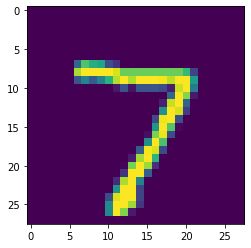

In [ ]:
plt.imshow(xtest[0])

In [ ]:
model.predict(xtest[0].flatten().reshape(1,-1))
np.argmax(model.predict(xtest[0].flatten().reshape(1,-1)))

array([[1.0722198e-04, 1.8297018e-04, 1.5624378e-04, 4.2343122e-04,
        1.3505264e-04, 1.2437984e-05, 5.8678427e-07, 9.8596257e-01,
        5.9968720e-06, 1.3013302e-02]], dtype=float32)

- Upload a pic and resize it to predict according to the model

In [ ]:
#!pip install scikit-image

     |████████████████████████████████| 12.1 MB 3.7 MB/s eta 0:00:01    |█████████████████▌              | 6.6 MB 3.7 MB/s eta 0:00:02███████████████▌      | 9.6 MB 3.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 21.6 MB/s eta 0:00:01�███████████████████▎     | 2.7 MB 21.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 148 kB 14.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 33.2 MB/s eta 0:00:01
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1


In [ ]:
import cv2

In [ ]:
from skimage.transform import resize
number = cv2.imread('16-30-31-241980.png')
number_gray = cv2.cvtColor(number, cv2.COLOR_BGR2GRAY)
number_resized_gray = resize(number_gray, (28,28))

In [ ]:
number_resized.shape

(28, 28, 3)

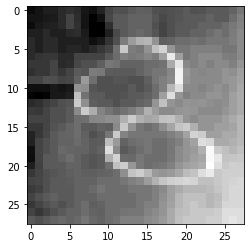

In [ ]:
plt.imshow(number_resized_gray,cmap='Greys')

In [ ]:
np.argmax(model.predict(number_resized_gray.flatten().reshape(1,-1)))

5

In [ ]:
model.predict(number_resized_gray.flatten().reshape(1,-1))

array([[4.98183910e-03, 1.26901884e-02, 2.75922613e-03, 2.77050375e-03,
        9.74668749e-03, 9.14933085e-01, 3.99721041e-03, 1.31021235e-02,
        9.08621412e-04, 3.41104791e-02]], dtype=float32)

In [ ]:
import cv2
from skimage.transform import resize
from os import listdir, walk
from os.path import isfile, join

def gray_reshape(directory, new_size = (28,28), gray =True):
    """
    give the list of photos with the correct pixel size you want to 
    downsize. If you want Gray then write True.
    """
    items_resized  =[]
    pictures = []
    labels = []
    mapping = {'books' : 1,'coins' : 2,'cups' : 3,'cutlery' : 4,'faces' : 5,'gestures' : 6,'glasses' : 7,'nail_polishes' : 8,'plants' : 9 }
    onlyfolders = [f for f in listdir(directory)]
    for idx, folder in enumerate(onlyfolders[1:]):
        pictures = [f for f in listdir(directory + folder) if isfile(join(directory + folder , f))]
        for idx, picture in enumerate(pictures):
            item = cv2.imread(directory + folder +'/'+ picture )
            labels.append(mapping[folder])
            if gray == True:
                item_gray = cv2.cvtColor(item, cv2.COLOR_BGR2GRAY)
                item_resized_gray = resize(item_gray, new_size)
                items_resized.append(item_resized_gray)
            else:
                item_resized_colored = resize(item, new_size)
                items_resized.append(item_resized_colored)
    return items_resized, labels

In [ ]:
X,y = gray_reshape('../output/', new_size = (28,28), gray =True);

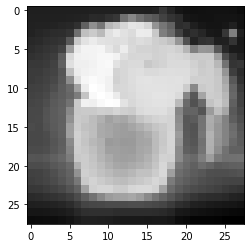

In [ ]:
plt.imshow(X[8],cmap='Greys')

In [ ]:
# Model / data parameters
num_classes = len(np.unique(y))
input_shape = (28, 28, 1)

In [ ]:
# shuffle the data
import numpy as np
import random
shuffler = np.random.permutation(len(X))
X = np.array(X)
y = np.array(y)
X = X[shuffler]
y = y[shuffler]

In [ ]:
# the data, split between train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# Scale images to the [0, 1] range
#### Normalise
x_train = X_train.astype("float32") / 255
x_test = X_test.astype("float32") / 255

In [ ]:
# Always always check shapes! 
x_train.shape, x_test.shape

((782, 28, 28), (261, 28, 28))

In [ ]:
# one hot encoder
from tensorflow import keras
y_train = keras.utils.to_categorical(y_train, num_classes+1)

y_test = keras.utils.to_categorical(y_test, num_classes+1)


In [ ]:
# define the keras model.    the kernel size is the window that checks geometries: can be (3,3), (5,5), (7,7)
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),   # number of neurons:  must be multiples of 2. good technique to start eith 8 and then we increase in the insede layers.
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.15),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

2022-05-11 21:10:37.970881: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# model summary table
model.summary()

# define the batch size and number of epochs
batch_size = 5
epochs = 50

In [ ]:


# complile and define eval metric
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# fit the model
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)